>> # **Statistic for AI and Data Science**
>>>>> # **Coursework 2**

## Introduction
The following analysis was carried out as part of an investigation on part of the Texas Department of Transportation (TDoT) regarding the conditions of the bridges of Texas state. The aim of this investigation is to check on the state of bridges so that necessary repairs can be carried out. If this is not done, a bridge can fail. The dataset has information about the bridges and the condition given in the most recent inspection.

The TDoT would normally use the three following variables in the dataset to derive the current condition of bridges:

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |


Nonetheless, the department wishes to investigate how well the following new variables could predict the condition of bridges and which of these proposed variables have more influence on the current condition:

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Year  (age)         | The year the bridge was built                             | continuous | 
|AverageDaily (average use)  | The average daily traffic (number of vehicles)            | continuous |
|Trucks_percent (percent trucks)| The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Historic       | Register, Possible, Unknown, Not historic |

This analysis aims to give answers to the above posed questions by both visually inspecting 'what the data says' but also 'how it has been processed'. That is, any conclusions (preliminary or final) and their underlying assumptions are also reasoned and discussed.


### Content

 1. **Section 1: Preparing the data**
      1. Creating a dataframe with relevant variables
      1. Deriving variable 'Age' for each bridge
      1. Excluding very old bridges based on two points (their age and how they are 'historically' classified)
      1. Reducing the number of categories of 'Material' and 'Design' (and the reasons behind it)
      1. Deriving a single integer Current Condition variable for each bridge based on selected ordinal categorical variables
      
 2. **Section 2: Exploratory Analysis**
      1. _Relationship between five predictor variables and target variable_
          * Predictor continuous variables and continuous target variable
          * Predictor categorical variables and continuous target variable
      1. _Relationship between predictor variables_
          * Continuous predictor variables
          * Categorical predictor variables and continuous predictor variables
          * Categorical predictor variables and categorical predictor variables
      1. _Summary of the findings and preliminary conclusions_
      
 3. **Section 3: Regression Modelling**
      1. Transforming categorical variables into dummy variables
      1. Checking for collinearity between variables used in regression analysis
      1. Dropping missing values from relevant columns of dataset
      1. Fitting the regression line - R2 coefficient, variables' coefficient results (comparing the coefficients), interpreting categorical coefficient outputs
      1. Prediction and the error distribution
      1. Plotting the regression line
      
 
     
 4. **Section 4: Final Conclusions and Suggestions**

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## **Section 1: Preparing the data**
### **Section 1.A: Creating a dataframe with relevant variables**

In [2]:
# The code below declares a catageorical type with categories in a specified order
# This can be used for an ordinal variable
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

# This one is also for an ordinal variable, but with a slightly different set of values
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)


types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges.head()  # uncomment to preview the data

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


Right after loading the required libraries, a `'type map'` is applied to the variables of the dataset which `specifies` the `type of each variable`. Rather than letting Pandas guess such types, it is given manually to categorical variables (which otherwise would be labelled as strings) and ordinal variables by explicitly stating the ordinal steps (or categories) of each variables (i.e., Deck_rating, Superstr_rating, Substr_rating, Scour_rating).


After this is done, the relevant variables are selected and included in a new dataframe, `table`. For the explanation of what these variables measure/mean, see the tables in Introduction.

In [3]:
# Creating a relevant dataframe with the specified variables
table = bridges[['Year', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Historic', 'Deck_rating',
                 'Superstr_rating', 'Substr_rating']]
table.head()

,Year,AverageDaily,Trucks_percent,Material,Design,Historic,Deck_rating,Superstr_rating,Substr_rating
Structure_id,,,,,,,,,
000021521-00101,2005,1,0.0,Concrete,Slab,Not historic,Good,Very Good,Very Good
000021521-00181,2005,1,0.0,Concrete,Slab,Not historic,Good,Good,Very Good
000021521-TMP20,2012,100,0.0,Concrete,Beam,Not historic,Very Good,Very Good,Very Good
000021525-00012,1950,80,0.0,Timber,Beam,Not historic,Good,Good,Poor
000021580-00092,2004,150,4.0,Concrete,Beam,Not historic,Good,Very Good,Very Good


### **Section 1.B: Deriving variable 'Age' for each bridge**

To make the data a bit tidier and more insightful (easier to interpret), it seemed that `from` variable `Year` an `Age` variable could be calculated (and then included in the table). 

In [4]:
# Derive an 'Age' variable from the Year variable (with age in years)
def calc_age(table):
    for row in table:
        age = (2021 - table.Year)
        return age

In [5]:
# Creating a pd dataframe for ages
bridge_age = pd.DataFrame().assign(Age = table.apply(calc_age, axis=1))

# Assigning the above dataframe to my table
table = table.assign(Age = bridge_age)

# Rearranging columns
table = table[['Year', 'Age', 'Historic','AverageDaily', 'Trucks_percent', 'Material', 'Design','Deck_rating',
                 'Superstr_rating', 'Substr_rating']]

# Print first few rows of my table
table.head()

,Year,Age,Historic,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating
Structure_id,,,,,,,,,,
000021521-00101,2005,16,Not historic,1,0.0,Concrete,Slab,Good,Very Good,Very Good
000021521-00181,2005,16,Not historic,1,0.0,Concrete,Slab,Good,Good,Very Good
000021521-TMP20,2012,9,Not historic,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good
000021525-00012,1950,71,Not historic,80,0.0,Timber,Beam,Good,Good,Poor
000021580-00092,2004,17,Not historic,150,4.0,Concrete,Beam,Good,Very Good,Very Good


### **Section 1.C: Excluding very old bridges based on two points (their age and how they are 'historically' classified)**

As the next step of the process of Data Preparation, outliers had to be removed from the data. This paper first checked the `descriptive statistics` of variable `Age`, then visualised its `histogram and boxplot`.

In [6]:
descr_stats = table.Age.describe()
descr_stats

count    34293.000000
mean        39.502581
std         23.860135
min          2.000000
25%         19.000000
50%         36.000000
75%         57.000000
max        121.000000
Name: Age, dtype: float64

Whilst the range of the bridges' age is 119 years, seventy-five percent of the data is under (or equal) to 57 years, with median value being 36 years. Based on these information and that the mean value is greater than the median we know already that the distribution is positively skewed. A reason for this could be that the dataset contains outlier bridges that are far away from the age that is characterised with most bridges. As such outlier bridges could seriously affect the results of later regression analyses, they needed to be removed. 


A histogram is constructed to check if outliers are visible straight away.

Text(114.0, 500, 'Q3 + 1.5(IQR): 114.00')

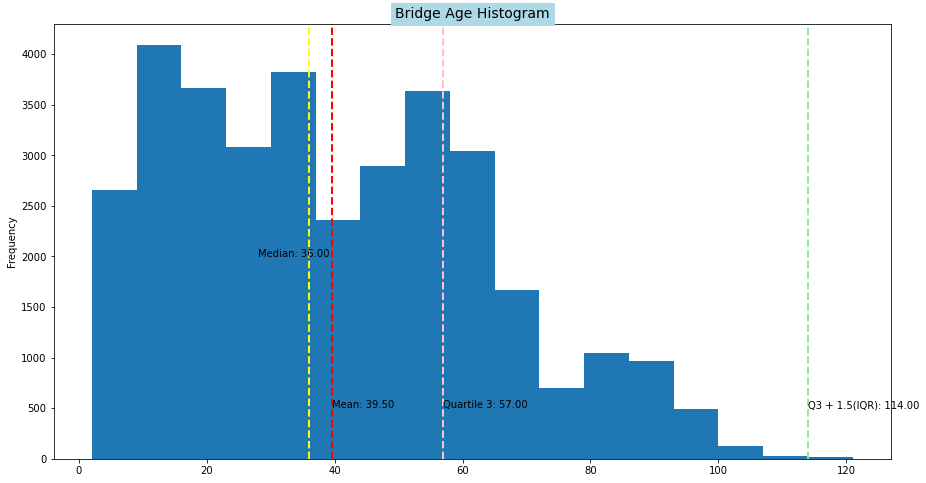

In [7]:
# Let's first see the histogram of 'Age'
age_hist = table.Age.plot(kind='hist', figsize=(15,8), bins=17)
plt.axvline(table.Age.mean(), color='red', linestyle='dashed', linewidth=2)
plt.text(table.Age.mean(),y=500, s='Mean: {:.2f}'.format(table.Age.mean()))
plt.axvline(table.Age.median(), color='yellow', linestyle='dashed', linewidth=2)
plt.text(table.Age.median()-8,y=2000, s='Median: {:.2f}'.format(table.Age.median()))
age_q3 = 57.00
plt.axvline(age_q3, color='pink', linestyle='dashed', linewidth=2)
plt.text(age_q3,y=500, s='Quartile 3: {:.2f}'.format(age_q3))
plt.title('Bridge Age Histogram', fontsize=14, backgroundcolor='lightblue')
topwhisker = 114.0
plt.axvline(topwhisker, color='lightgreen', linestyle='dashed', linewidth=2)
plt.text(topwhisker,y=500, s='Q3 + 1.5(IQR): {:.2f}'.format(topwhisker))

The positive skew of the distribution is clearly visible and that the age of bridges range considerably. Most bridges seem to have ages between 0 and 60, but there are quite a few with way more extreme values. 

Text(0.5, 1.0, 'Bridge Age Boxplot')

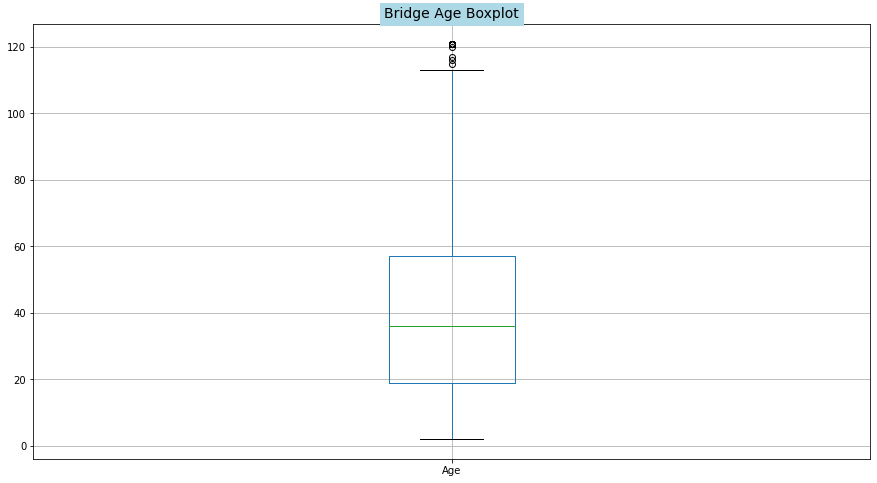

In [8]:
# Let's check the boxplot for 'Age', maybe we can determine a threshold for outliers
age_box = table.boxplot(column=['Age'], figsize=(15,8))
plt.title('Bridge Age Boxplot', fontsize=14, backgroundcolor='lightblue')

Similar observations can be made from the boxplot to those from the histogram:
* The boxplot is relatively short, meaning most bridges' age have no extreme variation. As suggested above, they tend to have ages between 0 and 60.
* Thee median is closer to the bottom of the box, and the whisker is shorter on the lower end of the box, then the distribution is positively skewed (skewed right).
* The four quartiles of the boxplot are uneven in size. This just means that, for example, in the First Quartile of the data bridges have roughly similar ages, whilst in the Third Quartile bridges' age will considerably vary.
* The dots outside the edge of the upper whisker of the boxplot represent the `outliers`. The `upper whisker's edge` can be calculated by `Q3 + 1.5*(interquartile range)`, which yields 114.0 years. However, considering that this would only eliminate 16 bridges (certainly would not corrigate for the skewed distribution of the data) this analysis took an extra criteria for identifying outliers. 


The dataset contains variable `Historic` with four categorical values: `Not historic, Possible, Register and Unknown`. Whilst these categories can be fairly informative in some cases, as the below visualisations and statistics show, their distribution ranges considerably and covers many years.

In [9]:
gbyHistorical = table.groupby(by = 'Historic', dropna=False)

def describeBy(groups, columns):
    for (index,grp) in groups:
        print('\nGroup', index)
        print('------------------')
        print(grp.loc[:,columns].describe())

describeBy(gbyHistorical, ['Age']) 


Group Not historic
------------------
                Age
count  19912.000000
mean      22.523755
std       11.491238
min        2.000000
25%       13.000000
50%       22.000000
75%       32.000000
max       91.000000

Group Possible
------------------
                Age
count  13906.000000
mean      62.617719
std       14.130098
min        3.000000
25%       52.000000
50%       59.000000
75%       70.000000
max      121.000000

Group Register
------------------
              Age
count  417.000000
mean    82.206235
std     18.186154
min      3.000000
25%     72.000000
50%     83.000000
75%     91.000000
max    121.000000

Group Unknown
------------------
             Age
count  58.000000
mean   19.431034
std    21.113820
min     4.000000
25%     5.000000
50%     5.000000
75%    43.000000
max    61.000000


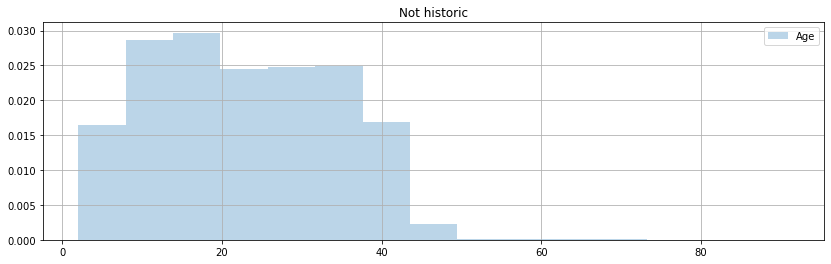

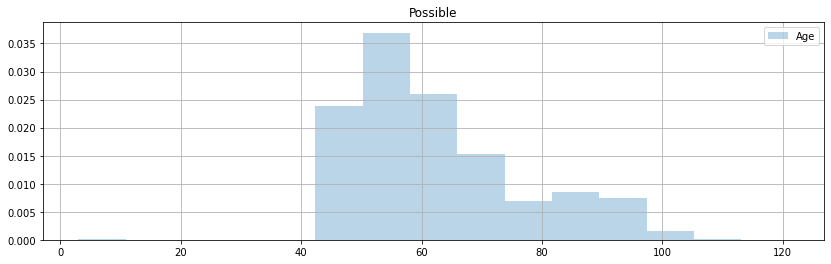

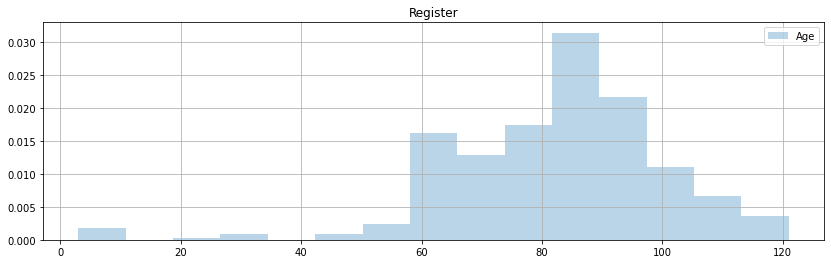

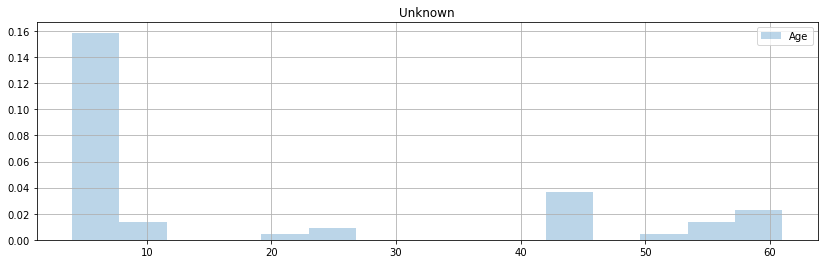

In [10]:
axs = gbyHistorical.hist(column=['Age'], alpha=0.3, bins=15, density=True, figsize=(14,4), sharex=True, legend=True)
      # The parameter log=True can be useful

# This sets the titles
names = ['Not historic', 'Possible', 'Register', 'Unknown']
_t = [axs[name][0][col].set_title(name) for name in names for col in [0]]

Taking each category and acquiring some statistics (and plotting their histograms) for them, given the Age of the bridges that fall into the respective categories, one can see that:
* `Q3 Age of Not historic` is 32.00 years ---> remove approx. upper 15% 
* `Q3 Age of Possible` is 70.00 years ---> remove upper 25%
* `Q1 Age of Register` is 72.00 years. ---> remove upper 75%


_Considering each categories' wide range it seemed sensible to cut off the upper 15-20% of data from 'Not historic' and 'Possible' and 75% of the data from 'Register'. The union of the three variable will lie at around Age 72, of which is taken as the threshold for outliers._ The below code removes all bridges that are over 72 years old. 

In [11]:
# # A function classifying bridges

table = table.loc[(table["Age"] <= 72)]                
table.head()

,Year,Age,Historic,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating
Structure_id,,,,,,,,,,
000021521-00101,2005,16,Not historic,1,0.0,Concrete,Slab,Good,Very Good,Very Good
000021521-00181,2005,16,Not historic,1,0.0,Concrete,Slab,Good,Good,Very Good
000021521-TMP20,2012,9,Not historic,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good
000021525-00012,1950,71,Not historic,80,0.0,Timber,Beam,Good,Good,Poor
000021580-00092,2004,17,Not historic,150,4.0,Concrete,Beam,Good,Very Good,Very Good


Replotting Age's boxplot and histogram shows that the outliers are removed and that the distribution of the variable is more normal than it was before. 

<AxesSubplot:>

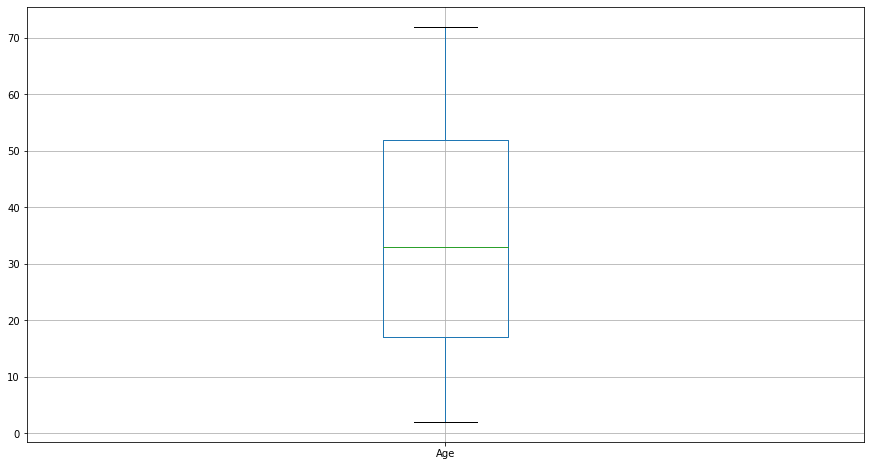

In [12]:
age_box2 = table.boxplot(column=['Age'], figsize=(15,8))
age_box2

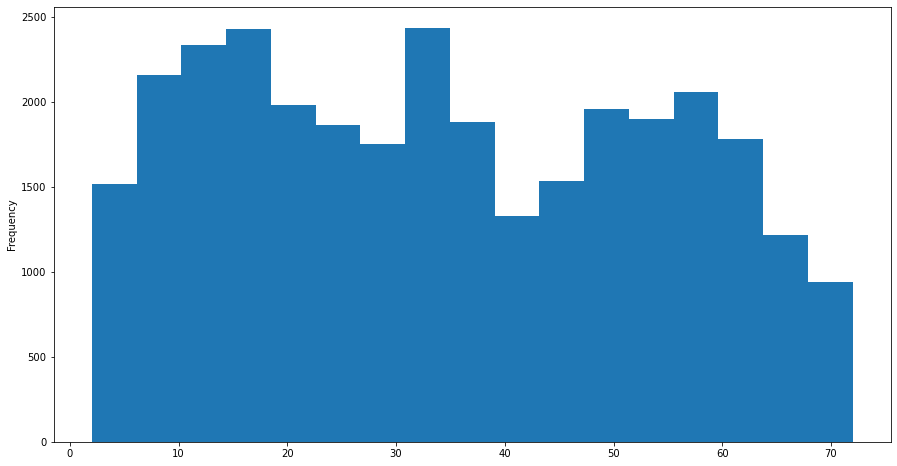

In [13]:
histogram2 = table.Age.plot(kind='hist', figsize=(15,8), bins=17)

### **Section 1.D: Reducing the number of categories of 'Material' and 'Design' (and the reasons behind it)**

##### **First, let's check their categorical variables**
| Variable      |      Values            |
|:--------------|:-----------------------|
|Material       | Other, Concrete, Steel, Timber, Masonry |
|Design         | Other, Slab, Beam, Frame, Truss, Arch, Suspension, Movable, Tunnel, Culvert, Mixed |

First, we want to find out which categories within 'Material' and 'Design' are the least frequent ones, ones which we could merge into 'Other'. To count how many bridges fall into each category of variable 'Material', a pivot table is created.

In [14]:
# Creating a pivot table for 'Material' to see its respective categories' frequencies
material_count = table.pivot_table(values=['Design'], index=['Material'], aggfunc='count')
material_count

,Design
Material,
Concrete,24895
Masonry,1
Other,42
Steel,5689
Timber,443


It seems clear that 'Masonry' and 'Timber' could easily be merged with 'Other' as their share of total bridges is negligible. The below code defines the categories that are carried further in the analysis ('Concrete', 'Steel' and 'Other') and then they get assigned to each bridge respectively. If a bridge's material is either 'Timber' or 'Masonry' it is changed to 'Other'.

#### **Reducing the categories of 'Material'**

In [15]:
# defining new categories for 'Material' (simplified)
material_categories = pd.CategoricalDtype(categories=['Concrete', 'Steel', 'Other'], ordered=False)

# creating a dictionary mapping existing to new values
material_dictionary = {'Concrete': 'Concrete', 'Steel': 'Steel', 'Masonry': 'Other', 'Other': 'Other', 'Timber': 'Other'}

# Define a function we can apply to map the values
def material_cat(row):
    if row.Material in material_dictionary:
        return material_dictionary[row.Material]
    return row.Material

# Apply the function
table = table.assign(Material = table.apply(material_cat, axis=1))

In [16]:
# Just checking whether we only have three categories left for 'Material'  ## Yes, it worked
material_count = table.pivot_table(values=['Design'], index=['Material'], aggfunc='count')
material_count

,Design
Material,
Concrete,24895
Other,486
Steel,5689


#### **Reducing the categories of 'Design'**

A similar procedure is carried out below for variable 'Design'. 

In [17]:
# Creating a pivot table for 'Design' to see its respective categories' frequencies
design_count = table.pivot_table(values=['Material'], index = ['Design'], aggfunc='count')
design_count

,Material
Design,
Arch,100
Beam,26410
Frame,65
Movable,11
Other,1215
Slab,3237
Suspension,3
Truss,29


The pivot table suggests that aaprt from 'Beam' and 'Slab', the rest of the categories ('Arch', 'Frame', 'Movable', 'Suspension', 'Truss') could be merged into 'Other'. The below code does just that in exactly the same way it did for the categories of 'Material'.

In [18]:
# defining new categories for 'Design' (simplified)
design_categories = pd.CategoricalDtype(categories=['Beam', 'Slab', 'Other'], ordered=False)

# creating a dictionary mapping existing to new values
design_dictionary = {'Beam': 'Beam', 'Slab': 'Slab', 'Arch': 'Other', 'Frame': 'Other', 'Movable': 'Other',
                      'Other': 'Other', 'Suspension': 'Other', 'Truss': 'Other'}

# Define a function we can apply to map the values
def design_cat(row):
    if row.Design in design_dictionary:
        return design_dictionary[row.Design]
    return row.Design

# Apply the function
table = table.assign(Design = table.apply(design_cat, axis=1))

In [19]:
# Checking whether we only have three categories left for 'Design' ## Yes, it worked
design_count = table.pivot_table(values=['Material'], index = ['Design'], aggfunc='count')
design_count

,Material
Design,
Beam,26410
Other,1423
Slab,3237


**Why are the above categories being merged?**


As the pivot tables of both 'Material' and 'Design' showed, categorical variables can have levels (inner categories) that rarely occur. Therefore, the chance that such categories will make a considerable impact on later regression fit is negligible. 

### **Section 1.E: Deriving a single integer Current Condition variable for each bridge based on the sum of selected (transformed) ordinal categorical variables**

As said earlier, TDoT derives the current condition of bridges from variables Deck_rating, Superstr_rating and Substr_rating of the bridges.

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

| Variable      |      Values            |
|:--------------|:-----------------------|
|Deck_rating    | *Rating*: NA, Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed |
|Superstr_rating| *Rating* |
|Substr_rating  | *Rating* |

All three variables are ordinal (categorical), which is a problem because in their raw forms they cannot be included in a regression equation - they must be treated. Therefore two steps are required to get a singular, continuous value for each bridge, representing current condition:<br>
    **1.** Convert ordinal values of all three variables to integers, using the mapping method whereby integers are assigned to each ordinal category (0 for 'Failed', 1 for 'Failing', 2 for 'Critical', etc.). <br>
    **2.** Create a new column where the above newly created integers summed up for each bridge are stored, respectively. 

#### **Defining integer categories for 'Deck_rating'**

In [20]:
# Defining integer categories for 'Deck_rating' 
deckrating_integer = pd.CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=True)

# Creating a dictionary mapping existing to new values
deckrating_dictionary = {'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4,
                        'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9,
                        'NA': 10}

# Define a function we can apply to map the values
def deckrating_integer(row):
    if row.Deck_rating in deckrating_dictionary:
        return deckrating_dictionary[row.Deck_rating]
    return row.Deck_rating

# Apply the function
table = table.assign(Deck_rating = table.apply(deckrating_integer, axis=1))

# Let's check if our ordinal categories have been transformed into integers
deckrating_var = table.pivot_table(values=['Material'], index = ['Deck_rating'], aggfunc='count')
print(deckrating_var)

             Material
Deck_rating          
0.0                 9
1.0                 2
2.0                 1
3.0                 1
4.0                63
5.0               960
6.0              6301
7.0             19514
8.0              4000
9.0               214


#### **Defining integer categories for 'Superstr_rating'**

In [21]:
# Defining integer categories for 'Superstr_rating' 
superstr_integer = pd.CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=True)

# Creating a dictionary mapping existing to new values
superstr_dictionary = {'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4,
                        'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9,
                        'NA': 10}

# Define a function we can apply to map the values
def superstr_integer(row):
    if row.Superstr_rating in deckrating_dictionary:
        return superstr_dictionary[row.Superstr_rating]
    return row.Superstr_rating

# Apply the function
table = table.assign(Superstr_rating = table.apply(superstr_integer, axis=1))

# Let's check if our ordinal categories have been transformed into integers
superstr_var = table.pivot_table(values=['Material'], index = ['Superstr_rating'], aggfunc='count')
print(superstr_var)

                 Material
Superstr_rating          
0.0                    12
2.0                     1
3.0                    15
4.0                    92
5.0                   939
6.0                  7402
7.0                 14502
8.0                  7751
9.0                   355


#### **Defining integer categories for 'Substr_rating'**

In [22]:
# Defining integer categories for 'Substr_rating' 
substr_integer = pd.CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=True)

# Creating a dictionary mapping existing to new values
substr_dictionary = {'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4,
                        'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9,
                        'NA': 10}
# Define a function we can apply to map the values
def substr_integer(row):
    if row.Substr_rating in substr_dictionary:
        return substr_dictionary[row.Substr_rating]
    return row.Substr_rating

# Apply the function
table = table.assign(Substr_rating = table.apply(substr_integer, axis=1))

# Let's check if our ordinal categories have been transformed into integers
substr_var = table.pivot_table(values=['Material'], index = ['Substr_rating'], aggfunc='count')
print(substr_var)

               Material
Substr_rating          
0                    12
1                     1
2                    19
3                    49
4                   278
5                  1762
6                  9064
7                 17006
8                  2721
9                   158


#### **Creating a new column in each row with the sum of the above variables' integers**

In [23]:
def calc_tot_int(table):
    for row in table:
        total = table.Deck_rating + table.Superstr_rating + table.Substr_rating
        return total
    
table = table.assign(Total_Rating = table.apply(calc_tot_int, axis=1))

In [24]:
# Rearranging columns, again
table = table[['Year', 'Age', 'Historic','AverageDaily', 'Trucks_percent', 'Material', 'Design','Total_Rating','Deck_rating',
                 'Superstr_rating', 'Substr_rating']]

The new column is added to `table` with variable name `Total_Rating`.

In [25]:
table.head()

,Year,Age,Historic,AverageDaily,Trucks_percent,Material,Design,Total_Rating,Deck_rating,Superstr_rating,Substr_rating
Structure_id,,,,,,,,,,,
000021521-00101,2005,16,Not historic,1,0.0,Concrete,Slab,23.0,7.0,8.0,8
000021521-00181,2005,16,Not historic,1,0.0,Concrete,Slab,22.0,7.0,7.0,8
000021521-TMP20,2012,9,Not historic,100,0.0,Concrete,Beam,24.0,8.0,8.0,8
000021525-00012,1950,71,Not historic,80,0.0,Other,Beam,18.0,7.0,7.0,4
000021580-00092,2004,17,Not historic,150,4.0,Concrete,Beam,23.0,7.0,8.0,8


With this final step, the Data Preparation stage of the analysis is completed. The following section attempts to investigate the relationship between the predictor variables themselves and the target variable. Based on these findings a preliminary conclusion is formed, before Section 3 carries out a regression analysis with final conclusions. 

## **Section 2: Exploratory Analysis**

### **Section 2.A: Relationship between five predictor variables and target variable**

The analysis starts with the relationship between predictor variables and the target variable. Since the predictors contain both continuous and categorical variables, the analysis is divided into two parts, both employing the appropriate techniques to gain some knowledge.

### **(i) `predictor continuous` variables and `continuous target` variable**

#### **Correlation Matrix**

In [26]:
# Correlation matrix
continuous_correlation = table.pivot_table(values=['Age','AverageDaily', 'Trucks_percent', 'Total_Rating'], index=['Structure_id'])
continuous_correlation.corr()

,Age,AverageDaily,Total_Rating,Trucks_percent
Age,1.000000,0.001140,-0.584613,0.236819
AverageDaily,0.001140,1.000000,0.010770,0.031165
Total_Rating,-0.584613,0.010770,1.000000,-0.044096
Trucks_percent,0.236819,0.031165,-0.044096,1.000000


#### **Correlation Heatmap of Correlation Table**

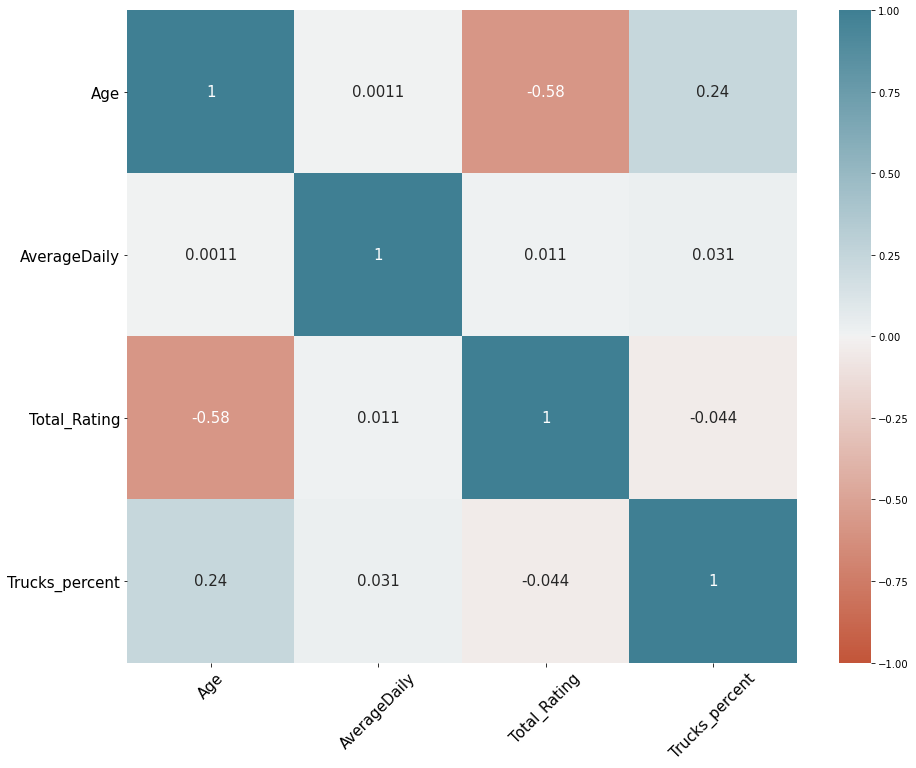

In [27]:
# Heatmap for correlation using seaborn
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(continuous_correlation.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20,220, as_cmap=True),
            annot=True, ax=ax, annot_kws={"size":15})

_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

Both the correlation table and correlation heatmap displays obviously the same values, but in a different visual format. What is clear is that there is not much correlation between the continuous variables and Total_Rating. There is only one exception: 'Age' and 'Total_Rating' negatively correlate with each other. Meaning as 'Age' increases, Total_Rating decreases. This seems a fairly reasonable assumption: the older the bridges get, the more problems will appear. Consequently, the current condition evaluated by Deck_rating, Superstr_rating and Substr_rating of the bridges will get lower ratings. 

#### **Scatterplot for Age~Total_Rating**

Since the relationship between 'Age' and 'Total_Rating' seemed to be the only one pair of variables that showcased considerable correlation, they are the ones plotted using a scatterplot. As the correlation is minor, it is hard to see it from the graph, although a slight negative slope of 'Total_Rating' is observable as 'Age' increases.

To get a clearer picture of this relationship, a sample of 5% of the total data is taken and plotted, giving a slightly better visualisation.

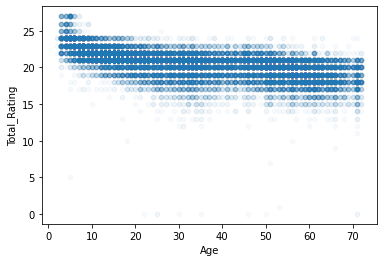

In [28]:
# Scatterplot between Age and Total_Rating
scatter = table.plot(kind='scatter', x='Age', y='Total_Rating', alpha=0.03)
# scatter = continuous_correlation.plot(kind='scatter', x='Age', y='Total_Rating', alpha=0.03)

<AxesSubplot:xlabel='Age', ylabel='Total_Rating'>

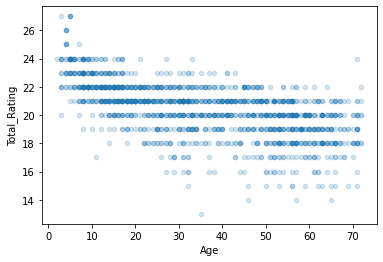

In [29]:
# Taking a sample of the data to see the negative relationship more clearly
table.sample(frac=0.05).plot(kind='scatter', x='Age', y='Total_Rating', alpha=0.2)

As it is suspected, further scatter plotting of the remaining continuous variables against Total_Rating does not produce any surprise. No correlation is observable between variables.

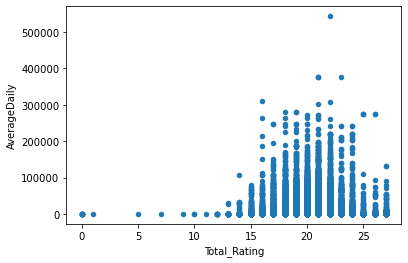

In [30]:
scatter2 = table.plot(kind='scatter', x='Total_Rating', y='AverageDaily')

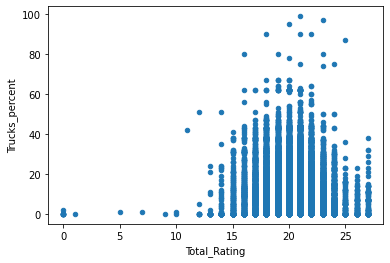

In [31]:
scatter3 = table.plot(kind='scatter', x='Total_Rating', y='Trucks_percent')

### **(ii)`predictor categorical` variables and `continous target` variables**

#### **Boxplot visualisation for 'Total_Rating' changes given the 'Material' and 'Design' value of bridges**

We are interested to understand how the target variable (Total_Rating) is correlated with our predictor categorical variables ('Material', 'Design'). This is, we can ask how the distribution of the 'Total_Rating' changes given the 'Material' and 'Design' value of the bridges. 

Text(0.5, 1.0, 'Total_Rating by Material Categories')

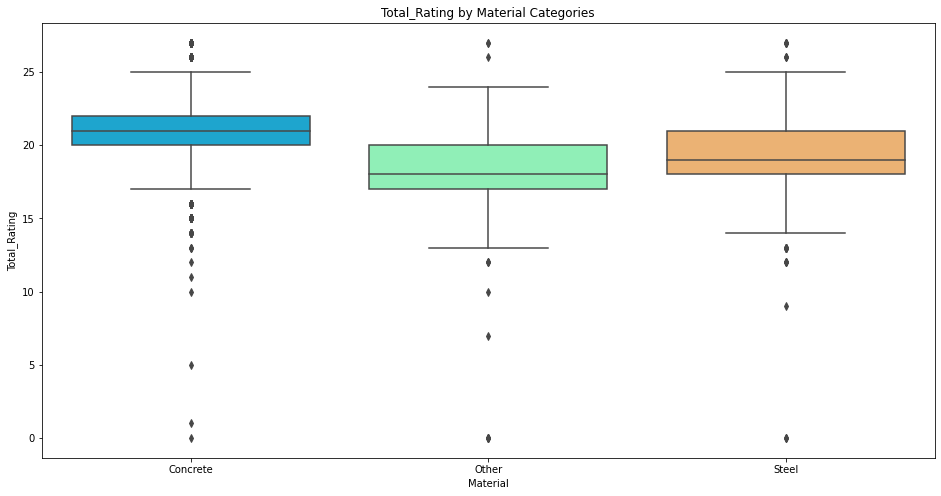

In [32]:
# Boxplot between Total_Rating | Material & Design values
plt.figure(figsize=(16,8))
sns.boxplot(x='Material',y='Total_Rating',data=table, palette='rainbow')
plt.title("Total_Rating by Material Categories") 

The above graph uses three boxplots representing the three levels of variable 'Material'. The example uses 'Material' as the horizontal variable for a boxplot. All 'Concrete' bridges are then displayed in the left boxplot, and all 'Steel' and 'Other' bridges are used in seperate boxplots. The above boxplot shows that the distribution of Total_Rating is different for the three levels of 'Material'. The lowest median Total_Rating is given to bridges with Material 'Other' (median=18.00, 486 bridges), whilst the highest median rating is achieved by 'Concrete'bridges (median=21.00, 24,890 bridges). Steel bridges (median=19.00, 5,688 bridges) perform only sligtly better than 'Other' bridges.

* Concerning variability of ratings, all three levels of 'Material' seem to have similar variability around their median in terms of acquired ratings.

* Regarding outlier bridges, most lower ratings are acquired by 'Concrete' bridges, whilst 'Other' and 'Steel' bridges get lower ratings evenly.
* Based on these findings, one could expect 'Concrete' bridges to be positively associated with Total_Rating more than the other two levels of 'Material'.

Text(0.5, 1.0, 'Total_Rating by Design Categories')

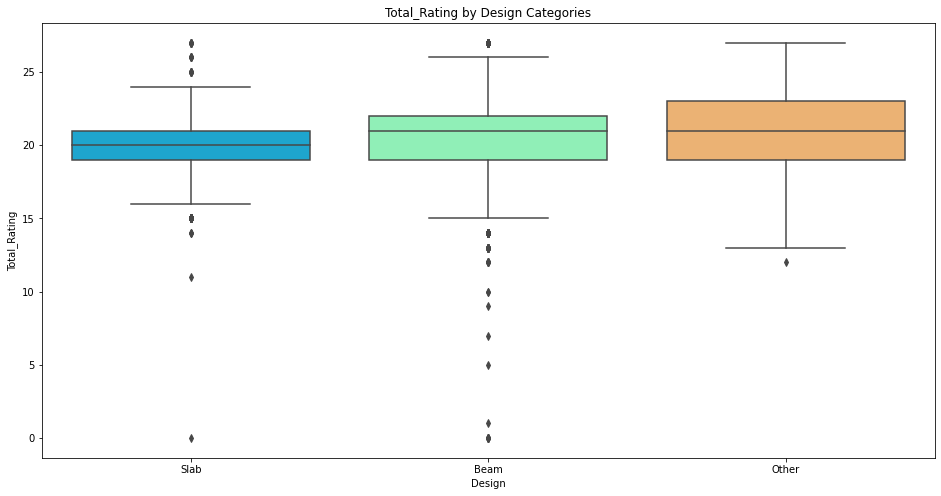

In [33]:
plt.figure(figsize=(16,8))
sns.boxplot(x='Design',y='Total_Rating', data=table, palette='rainbow')
plt.title("Total_Rating by Design Categories")

The same visualisation technique is applied to the levels (plotted along the horizontal axis) of variable 'Design' against Total_Rating. Inspecting their median values, one can see that 'Other' (1,418 brides) and 'Beam' briges (26,409 bridges) get the highest median ratings (median=21), whilst 'Slab' bridges (3,237 bridges) are slightly behind.

* Concerning variability of ratings, all three levels of 'Design' seem to have similar variability around their median in terms of acquired ratings.
* Regarding outlier bridges, most lower ratings are acquired by 'Beam' bridges (the worst bridges), skewing the distribution to the right.

The basic descriptive statistics included in the above analysis of the boxplots were extracted from the descriptive statistics table generated below.

#### **Applying Groupby Method to generate descriptive statistics for categorical variables**

In [34]:
gbyMaterial = table.groupby(by = 'Material', dropna=False)
gbyDesign = table.groupby(by= 'Design', dropna=False)

**GroupBy Functions**

The following code uses describe() on each of the groups in a GroupBy object (created using the groupby method). Look at the results. 

In [35]:
# Describing the categories of 'Material' or 'Design' (their relationship with 'Total_Rating')
def describeBy(groups, columns):
    for (index,grp) in groups:
        print('\nGroup', index)
        print('------------------')
        print(grp.loc[:,columns].describe())

print(f"Material's categories and their statistics in relation to Total_Rating: ")
print(describeBy(gbyMaterial, ['Total_Rating']))
print()
print('---------------------------------------------------------------------------')
print('---------------------------------------------------------------------------')
print('---------------------------------------------------------------------------')
print()
print(f"Design's categories and their statistics in relation to Total_Rating: ")
print(describeBy(gbyDesign, ['Total_Rating']))

Material's categories and their statistics in relation to Total_Rating: 

Group Concrete
------------------
       Total_Rating
count  24890.000000
mean      20.816031
std        1.753670
min        0.000000
25%       20.000000
50%       21.000000
75%       22.000000
max       27.000000

Group Other
------------------
       Total_Rating
count    486.000000
mean      17.874486
std        3.068074
min        0.000000
25%       17.000000
50%       18.000000
75%       20.000000
max       27.000000

Group Steel
------------------
       Total_Rating
count   5688.000000
mean      19.246835
std        1.857195
min        0.000000
25%       18.000000
50%       19.000000
75%       21.000000
max       27.000000
None

---------------------------------------------------------------------------
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Design's categories and their statistics in relation 

### **Section 2.B: Relationship between Predictor Variables**

### **`Continuous predictor variables`:**

#### **Correlation Matrix**

In [36]:
# From the already used Correlation matrix you can easily find the correlation values for Age, AverageDaily, Trucks_percent
continuous_correlation2 = table.pivot_table(values=['Age','AverageDaily', 'Trucks_percent'], index=['Structure_id'])
continuous_correlation2.corr()

,Age,AverageDaily,Trucks_percent
Age,1.000000,0.001140,0.236819
AverageDaily,0.001140,1.000000,0.031165
Trucks_percent,0.236819,0.031165,1.000000


#### **Correlation Heatmap for 'Age', 'AverageDaily' and 'Trucks_percent'**

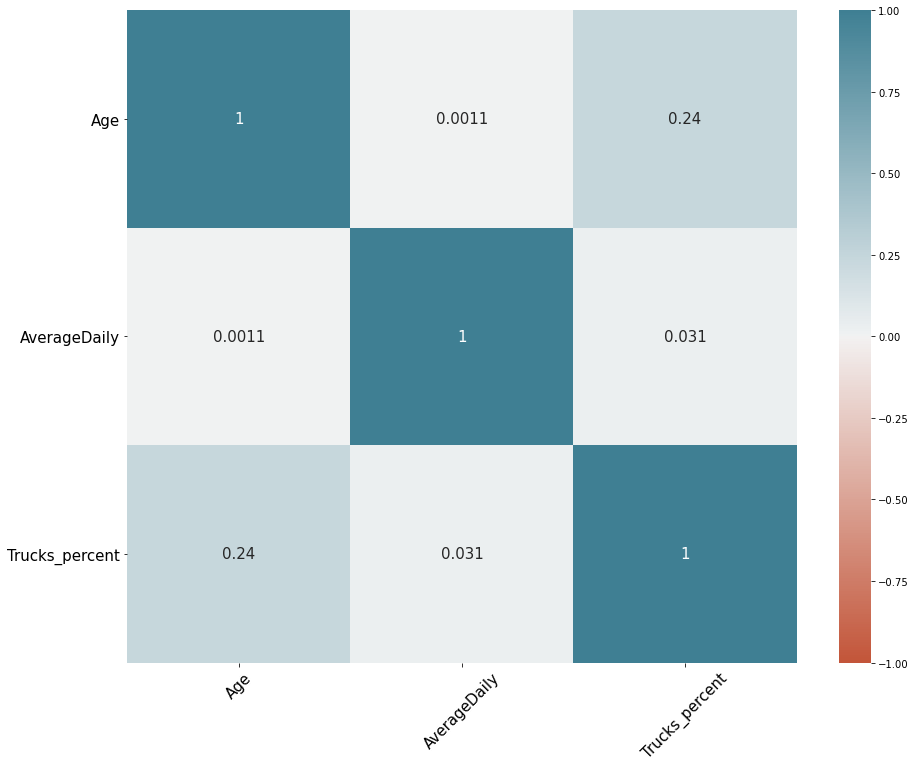

In [37]:
# Heatmap for correlation using seaborn
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(continuous_correlation2.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20,220, as_cmap=True),
            annot=True, ax=ax, annot_kws={"size":15})

_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

After creating a Correlation Matrix table and heatmap containing the continuous predictor variables 'Age', 'AverageDaily' and 'Trucks_percent', the only variables that could be picked as correlating are Trucks_percent and Age (0.24). Plotting them below shows a very slightly increasing level of Trucks_percent as Age increases. The reason behind this could be that with the age of a bridge increasing, the bridge becomes more known or
built around with more infrastructure, a more populous city, etc. 

#### **Age ~ Trucks_percent**

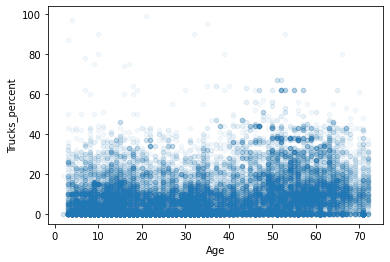

In [38]:
# Scatterplot between Age and Trucks_percent
scatter = continuous_correlation2.plot(kind='scatter', x='Age', y='Trucks_percent', alpha=0.05)

<AxesSubplot:xlabel='Age', ylabel='Trucks_percent'>

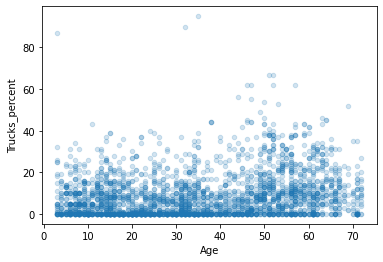

In [39]:
# Taking a sample of the data to see the negative relationship more clearly
continuous_correlation2.sample(frac=0.1).plot(kind='scatter', x='Age', y='Trucks_percent', alpha=0.2)

### **`Categorical predictor variables ~ Continuous predictor variables`**<br>
#### **Material ~ Age**

#### Kernel Density Estimation of Material~Age

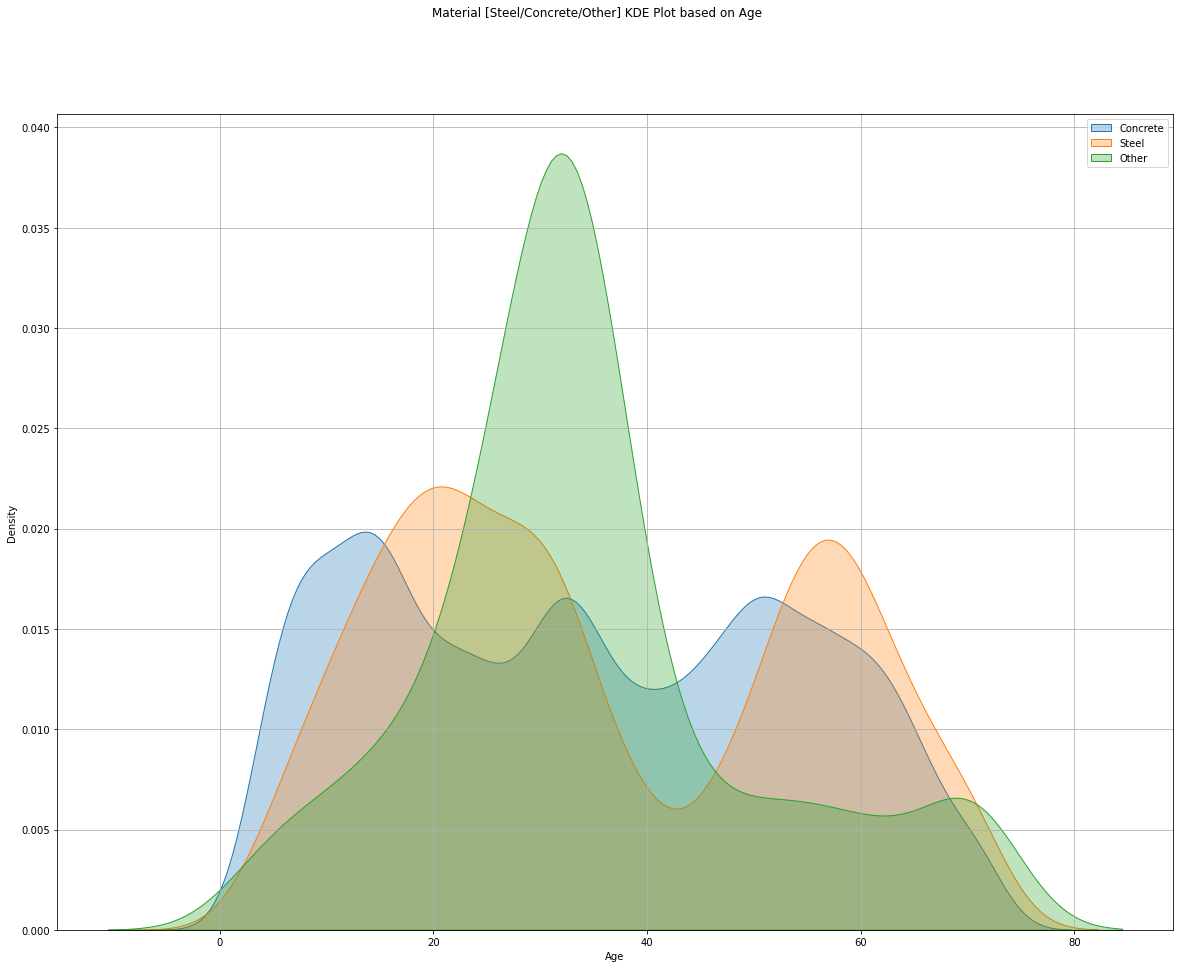

Text(0.5, 17.200000000000003, 'Age')

In [40]:
# KDE for Material's categories
m_concrete = gbyMaterial.get_group('Concrete')
m_steel = gbyMaterial.get_group('Steel')
m_other = gbyMaterial.get_group('Other')

fig, ax1 = plt.subplots(1, 1, figsize=(20,15))
var = 'Age'

sns.kdeplot(data=m_concrete[var], label='Concrete', ax=ax1, alpha=0.3, shade=True, legend=True)
sns.kdeplot(data=m_steel[var], label='Steel', ax=ax1, alpha=0.3, shade=True, legend=True)
sns.kdeplot(data=m_other[var], label='Other', ax=ax1, alpha=0.3, shade=True, legend=True)

plt.suptitle("Material [Steel/Concrete/Other] KDE Plot based on Age")
plt.grid()
plt.legend()
plt.show()


ax1.set_xlabel(var)

'A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve (function) in one or more dimensions in a non-parametric way (no assumptions about underlying distributions).' 

The above KDE plot shows 'Age' on the horizontal axis, with probability density on the vertical axis. It can be seen that bridges with 'Other' Material will have the highest probability of being (approximately) between Age 20 to 43. Moreover, 'Steel' bridges have a bimodal probability density distribution with peak values around Age 20 and 55. 'Concrete' bridges show a relatively even probability density distribution throughout the whole range of Age.

#### **Material ~ DailyAverage**

#### Boxplot of Material~AverageDaily

In [41]:
# Taking the natural logarithm of both AverageDaily and Trucks_percent
np.seterr(divide = 'ignore')
table = table.assign(AverageDailyLog = np.log10(table.AverageDaily),
                         TruckspercentLog = np.log10(table.Trucks_percent))

In order to effectively see the relationship between Material of bridges and the average daily traffic (number of vehicles, i.e. AverageDaily), AverageDaily's natural log was taken. 

Text(0.5, 1.0, 'Natural Log of AverageDaily by Material')

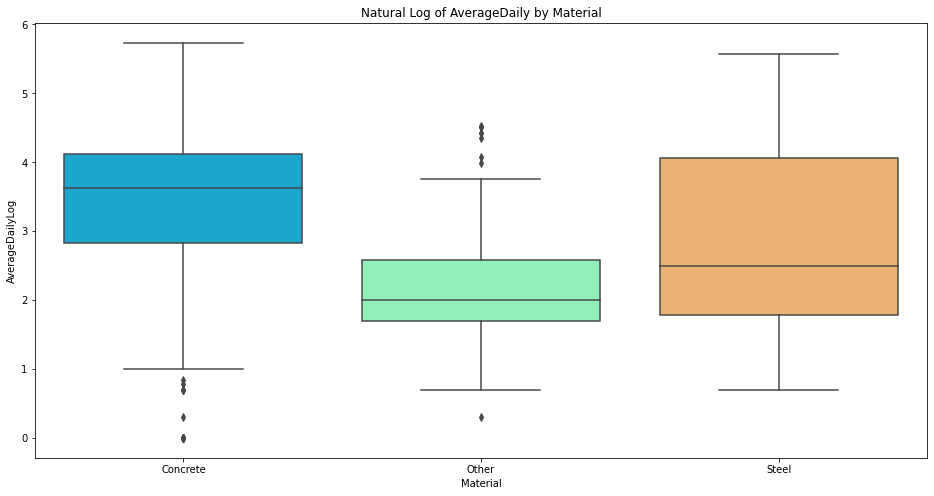

In [42]:
plt.figure(figsize=(16,8))
sns.boxplot(x='Material',y='AverageDailyLog', data=table, palette='rainbow')
plt.title("Natural Log of AverageDaily by Material")

The above plot shows that 'Concrete' bridges' have the highest median daily number of vehicles running through them (although with highest variability too), followed by 'Steel' and 'Other' bridges, respectively. The lower number vehicle bridges seem to be related to Concrete bridges. 

#### **Material ~ Trucks_percent**

#### Boxplot for Material~Trucks_percent

Text(0.5, 1.0, 'Trucks_percent by Material')

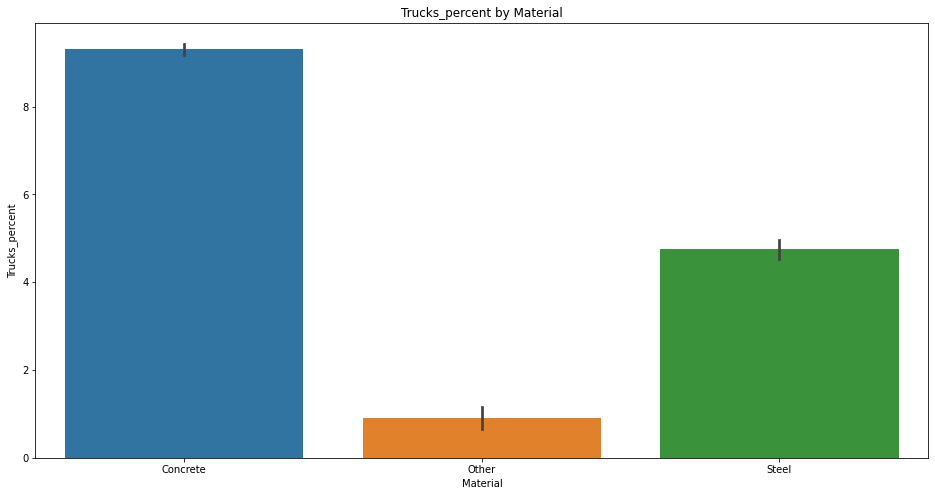

In [43]:
plt.figure(figsize=(16,8))
sns.barplot(x="Material", y="Trucks_percent", data=table)
plt.title("Trucks_percent by Material")

The percent of traffic made up of 'trucks' (i.e. lorries) is highest for 'Concrete' bridges (around 9 percent), followed by 'Steel' bridges (bit above 4 percent) and by 'Other' bridges (around 1 percent).

#### **Design ~ Age**

#### Kernel Density Estimation for Design~Age

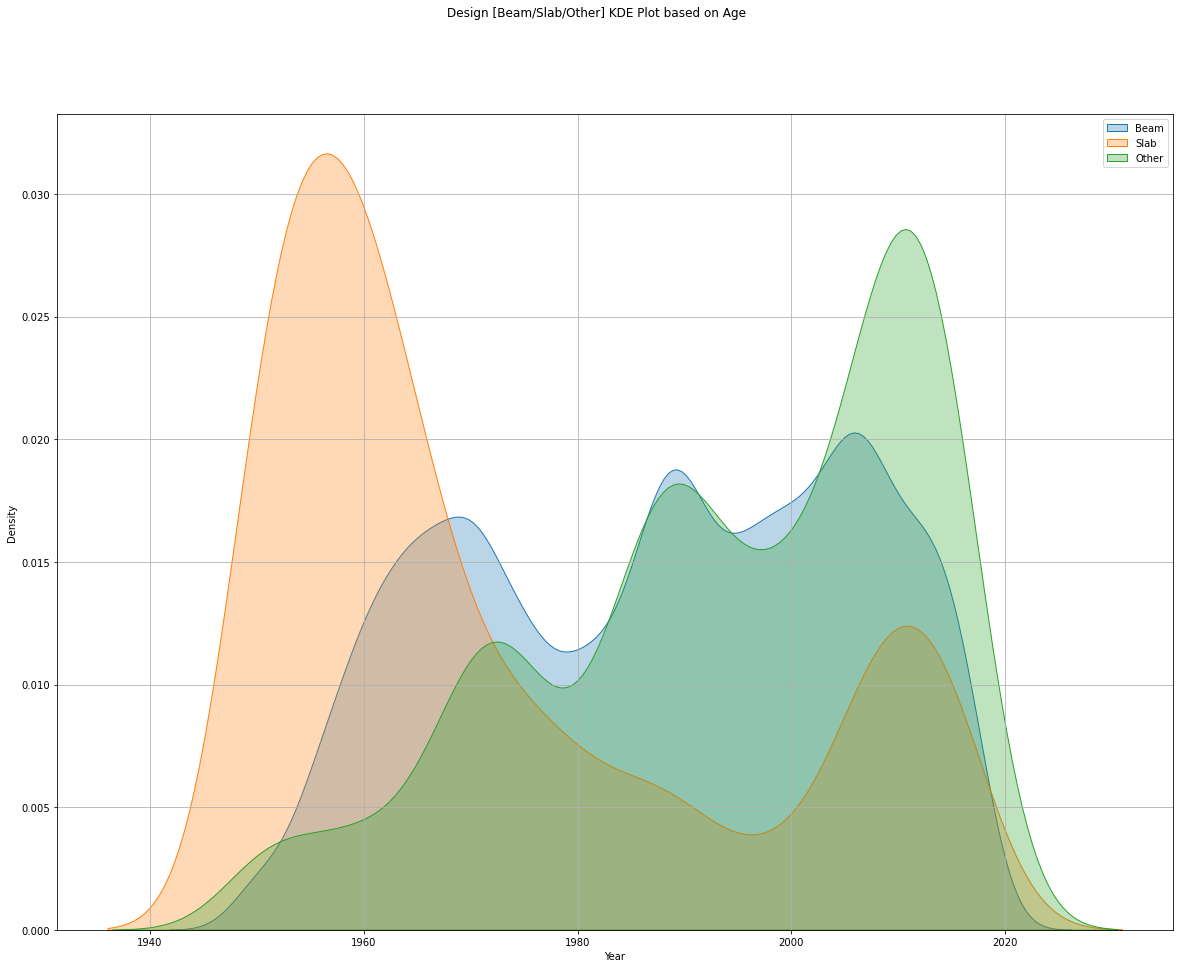

Text(0.5, 17.200000000000003, 'Year')

In [44]:
# KDE for Design's categories
d_beam = gbyDesign.get_group('Beam')
d_slab = gbyDesign.get_group('Slab')
d_other = gbyDesign.get_group('Other')

fig, ax1 = plt.subplots(1, 1, figsize=(20,15))
var = 'Year'

sns.kdeplot(data=d_beam[var], label='Beam', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=d_slab[var], label='Slab', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=d_other[var], label='Other', ax=ax1, alpha=0.3, shade=True)

plt.suptitle("Design [Beam/Slab/Other] KDE Plot based on Age")

plt.grid()
plt.legend()
plt.show()

ax1.set_xlabel(var)

The above Kernel Density Estimation plot shows the probability density of the three levels of bridge Design ('Beam', 'Slab' and 'Other') in relation to the 'Age' of bridges. To get a better feel of what is happening, 'Age' was substituted by its original form 'Year'. Three dynamics probably worth mentioning: 'Slab' Design bridges' popularity gradually declined over the decades (although with a resurgence around 2010); 'Other' designed bridges experienced a continuous popularity-gain since 1940; and finally, 'Beam' designed bridges enjoy a relatively even distribution over the years. 

#### **Design ~ Trucks_percent**

#### Barchart for Design~Trucks_percent

Text(0.5, 1.0, 'Trucks_percent by Design')

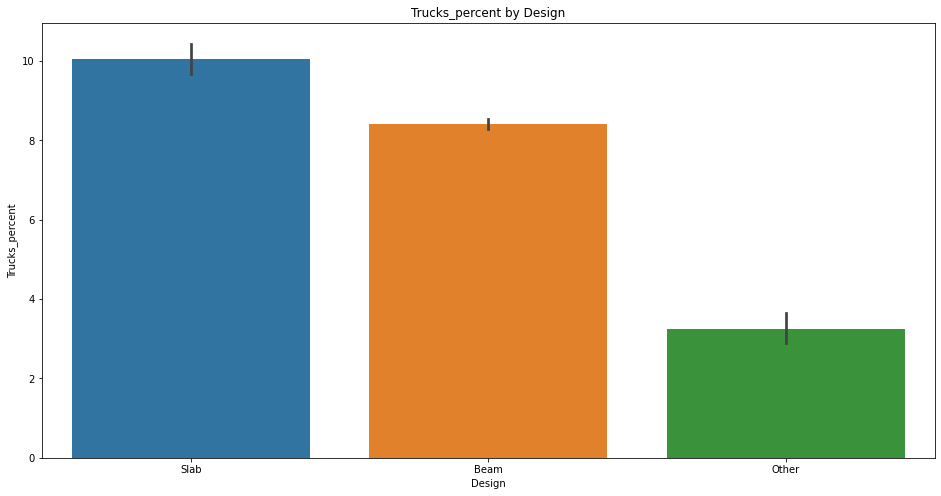

In [45]:
plt.figure(figsize=(16,8))
sns.barplot(x="Design", y="Trucks_percent", data=table)
plt.title("Trucks_percent by Design")

Continuing with 'Design' relationship with Trucks_percent, the above barchart shows that the percent of traffic made up of trucks is highest for 'Slab' designed bridges (around 10 percent), followed by 'Beam' bridges (bit above 8 percent) and by 'Other' designed bridges (around 3 percent).

#### **Design ~ AverageDaily**

#### Boxplot of Design~AverageDaily

Inspecting the relationship between 'Design' and 'AverageDaily', the below boxplot shows that 'Beam' bridges will experience the highest median daily number of vehicles, followed by 

Text(0.5, 1.0, 'Natural Log of AverageDaily by Design')

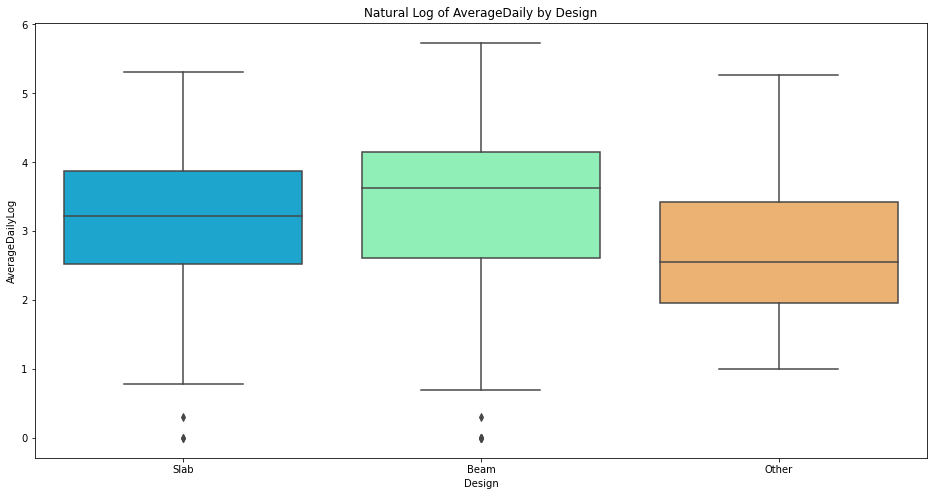

In [46]:
plt.figure(figsize=(16,8))
sns.boxplot(x='Design',y='AverageDailyLog', data=table, palette='rainbow')
plt.title("Natural Log of AverageDaily by Design")

In [47]:
# cond_plot = sns.FacetGrid(data=table, col='Total_Rating', col_wrap=10)
# cond_plot.map(sns.scatterplot, 'Material', 'Age');

### **`Categorical predictor variable vs categorical predictor variable`**

#### **Design ~ Material**

#### Calculating joint probabilities of Material and Design

Joint probability is the probability that the Material and Design variables each take on a specific value at the same point in time. For example, the below table depicts that the joint probability of a bridge being (naming the most important observations):
* `Material(Concrete) AND Design(Beam)` = 66.41 ---> The likelihood that concrete bridges are built with Beam design technique is 66.41 (where 0 is impossibility and 1 is certainty)
* `Material(Steel) AND Design(Beam)` = 17.18 ---> The likelihood that steel bridges are built with Beam design techique is 17.18.



In [48]:
# Joint probabilities of Material and Design
material_and_design = pd.crosstab(table.Material, [table.Design], normalize='all')
design_and_material = pd.crosstab(table.Design, [table.Material], normalize='all')
material_and_design_tot = pd.crosstab(table.Material, [table.Design], normalize='all', margins=True)

print(f"Joint probability of Material and Design Total in percentages: ")
print('----------------------------------------------------')
display(material_and_design_tot.round(4) * 100)

Joint probability of Material and Design Total in percentages: 
----------------------------------------------------


Design,Beam,Other,Slab,All
Material,,,,
Concrete,66.40,3.31,10.42,80.13
Other,1.43,0.14,0.00,1.56
Steel,17.18,1.13,0.00,18.31
All,85.00,4.58,10.42,100.00


#### Calculating conditional probabilities of Material and Design

Conditional probability is the probability of a categorical variable taking on a particular value _given the condition that the other categorical variable has some particular value_. For example, P(Concrete **given** Beam) means we look first at all Beam designed built bridges, then identify the Beam bridges that are Concrete (in this case, the likelihood is 78.11). 


Following the definition, all three conditional probabilities of the 'Material given Design' table are interesting: 
* Given all three types of designs of bridges (Beam, Slab, Other), there is a very high likelihood that bridges are concrete in material (certain for Slab designed bridges).

In [49]:
# Conditional probabilities - normalise index
material_given_design = pd.crosstab(table.Design, [table.Material], normalize='index')
design_given_material = pd.crosstab(table.Material, [table.Design], normalize='index')
print(f"Conditional probability of Material given Design in percentages: ")
print('----------------------------------------------------')
display(material_given_design.round(4) * 100)

Conditional probability of Material given Design in percentages: 
----------------------------------------------------


Material,Concrete,Other,Steel
Design,,,
Beam,78.11,1.68,20.21
Other,72.24,3.02,24.74
Slab,100.00,0.00,0.00


And similarly, given all three materials (Concrete, Steel, Other), there is an overwhelmingly high likelihood that the design is Beam.

In [50]:
print(f"Conditional probability of Design given Material in percentages: ")
print('----------------------------------------------------')
display(design_given_material.round(4) * 100)

Conditional probability of Design given Material in percentages: 
----------------------------------------------------


Design,Beam,Other,Slab
Material,,,
Concrete,82.87,4.13,13.0
Other,91.15,8.85,0.0
Steel,93.81,6.19,0.0


These findings regarding joint and conditional probabilities of Material and Design can be showcased through multiple visualisation techniques. This analysis uses barcharts and heatmaps to highlight the previously found high likelihood of a bridge being: <br>
* concrete AND built with beam design
* given design types, bridges have a high likelihood to be concrete
* given material types, bridges have a high likelihood to be Beam designed

#### Visualising joint and conditional probabilities calculated above using bar charts

Text(0.5, 1.0, 'Probability of Design, given Material')

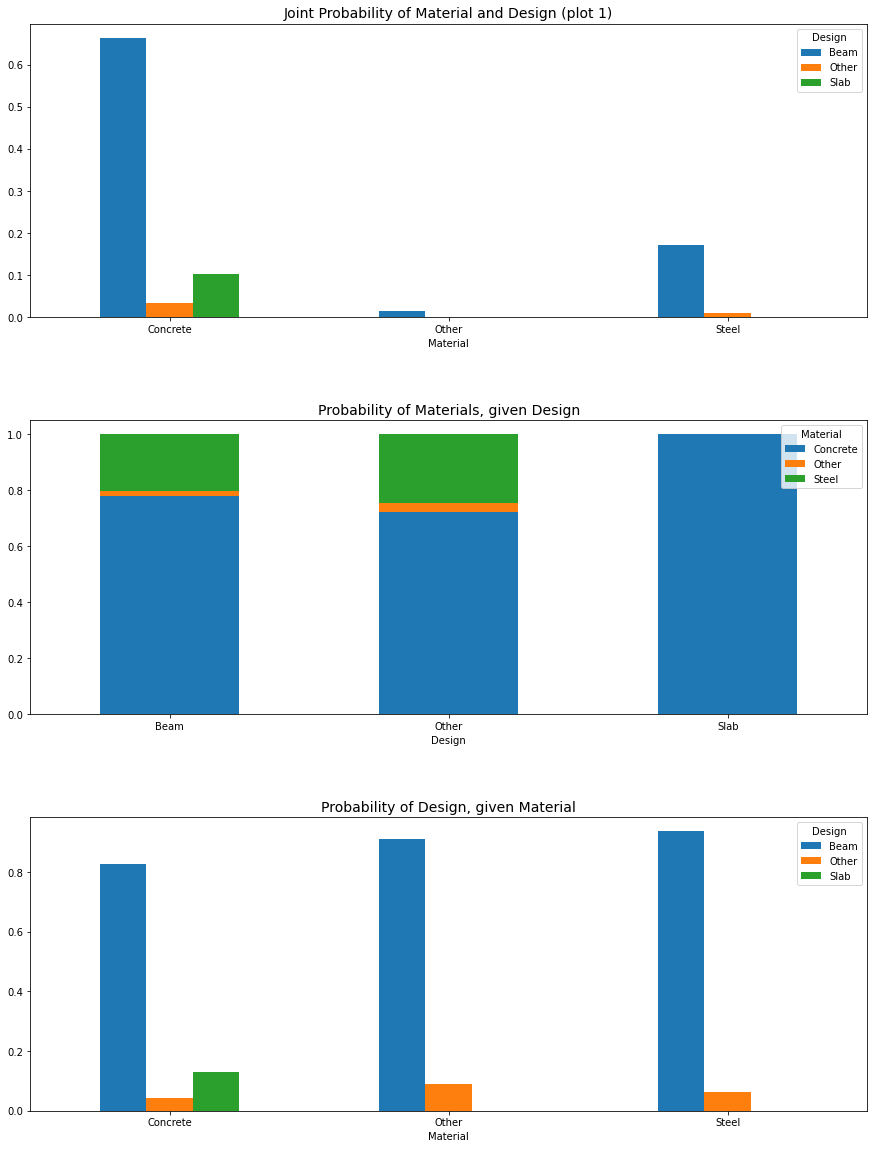

In [51]:
# Generate suitable axes
fig,(a1, a2, a3) = plt.subplots(3,1,figsize=(15,20), sharey=False, sharex=False)
fig.subplots_adjust(hspace=0.35)

# Plot one tabulation on each axis WITH CAREFUL TITLES
material_and_design.plot(kind='bar', subplots=False, ax=a1, rot=0)
a1.set_title('Joint Probability of Material and Design (plot 1)', fontsize=14)

material_given_design.plot(kind='bar', subplots=False, ax=a2, rot=0, stacked=True)
a2.set_title('Probability of Materials, given Design', fontsize=14)

design_given_material.plot(kind='bar', subplots=False, ax=a3, rot=0, stacked = False)
a3.set_title('Probability of Design, given Material', fontsize=14)

#### Visualising conditional probabilities of Material | Design calculated above using a Heatmap

Text(0.5, 1.0, 'Material given Design Structures')

<Figure size 432x288 with 0 Axes>

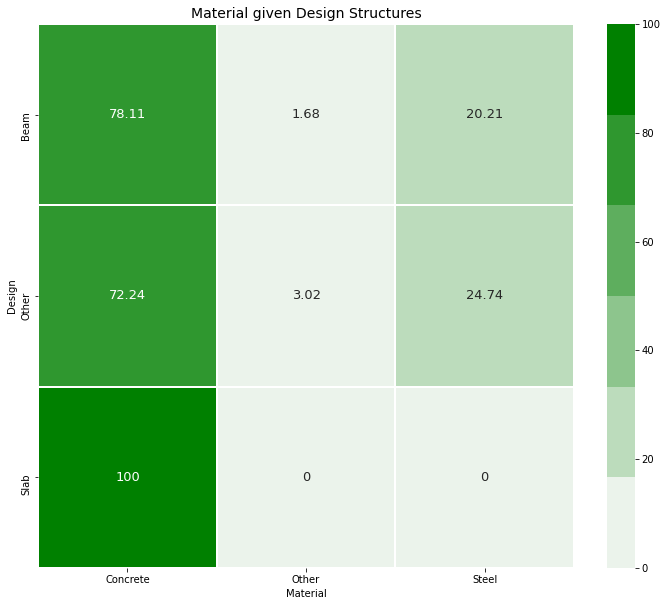

In [52]:
# Heatmap of (Conditional) Probabilities

material_given_design = pd.crosstab(table.Design, [table.Material], normalize='index')
plt.suptitle('Material given Design Structures', fontsize=14, fontweight='bold')
fig,ax = plt.subplots(1,1, figsize=(12,10))
sns.heatmap(material_given_design.round(4)*100, cmap=sns.light_palette('green'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Material given Design Structures', fontsize=14)

#### **Visualising conditional probabilities of Design | Material calculated above using Heatmap**

Text(0.5, 1.0, 'Design given Main Materials')

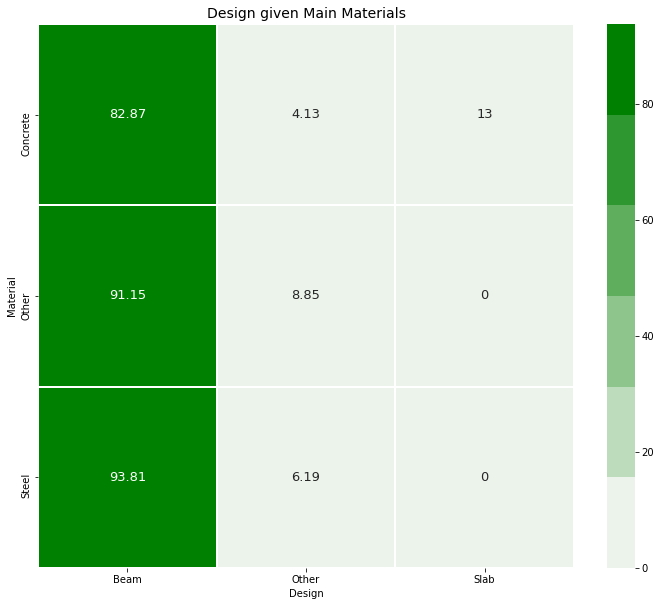

In [53]:
# Heatmap of (Conditional) Probabilities

design_given_material = pd.crosstab(table.Material, [table.Design], normalize='index')

fig,ax = plt.subplots(1,1, figsize=(12,10))
sns.heatmap(design_given_material.round(4)*100, cmap=sns.light_palette('green'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Design given Main Materials', fontsize=14)

## **Section 2.C: Summary of the findings and preliminary conclusions:**
Before drawing preliminary conclusions about the relationships discovered above, a list of the most important ones can be found below:

#### **Predictors ~ Target**<br>
`Continuous predictor ~ Target`<br>
The only considerable relationship seemed to be between **Age** and Total_Rating (-0.58). That is, the older bridges get, the lower ratings they will receive. 

`Categorical predictor ~ Target`<br>
* Although the highest median total rating received by **Material** categories was Concrete, it was established that this category also acquires the lower ratings (outliers). 

* Although the highest median rating was received by Beam designed bridges, this **Design** category also includes the worst rated bridges. 


#### **Predictors ~ Predictors** <br>
`Continuous predictor ~ Continuous predictor`<br>
* The only considerable relationship picked up in this section was the slight positive correlation between **Age and Trucks_percent**. It was said that this could be since as bridges age, they become more known or built around infrastructurally, etc.  

`Continuous predictor ~ Categorical predictor`<br>
* Material~ Age: does not seem too interesting (Concrete seems to be evenly distributed over the years without a considerable skew...)
* Material~DailyAverage: concrete bridges are associated with highest median value of vehicles that run through them daily, although they also include the bridges with lowest number vehicles (outliers). 
* Material ~ Trucks_percent: concrete bridges’ traffic is made up of the highest percentage of trucks (around 9%). 


* Design ~ Age: does not seem particularly interesting. ‘Other’ gained popularity, ‘Slab’ declined in application, whilst ‘Beam’ kind of remained on similar levels throughout the decades. 
* Design ~ Trucks_percent: does not seem too interesting either. 
* Design ~ AverageDaily: does not seem too interesting. 


`Categorical predictor ~ Categorical predictor`<br>
* All joint and conditional probabilities imply a strong dependence between material and design types. 


### **Preliminary Conclusions:**
It seems that Total_Rating (constructed from three variables; representing the current condition of bridges) is predominantly affected by three variables: Age, Material and Design. 

- Whilst age is clearly negatively correlated with total rating of bridges, it is also positively correlated with trucks_percent, and its relationship varies with the levels Material and Design. How it will ultimately affect Total_Rating will probably depend on the strength of the positive correlation between trucks_percent, Material and Design categories.<br>


- Regarding Material's levels, concrete bridges were said to include the lower/lowest rated bridges (this could be a negative affect on Total_Rating in the end). What could be the reason behind this? For one, it is plausible that there is a shorter lifespan for concrete bridges, after which they start eroding as receiving lower ratings (hence the indirect connection between Material and Age, which is otherwise not too clear from the KDE plot drawn above).<br>


- Concerning Design's levels, Beam designed bridges were similarly found to encompass the worst rated bridges. It is interesting, as it was shown later that both joint and conditional probabilities of  Beam and Concrete bridges are particularly strong, implying a possible strong joint negative relationship on Total_Rating (when bridge is both concrete and beam designed).

# **Section 3: Regression Modelling**

Before proceeding to the regression model, the predictor variables should not be collinear - i.e., perfect correlation between predictor variables, that is, linear relationship between them, obstructing the independent prediction value for the dependent variable. In order to visualise the relationship between the predictor variables, the categorical variables first need to be transformed into dummy variables.

#### **Section 3.A: Transforming categorical variables into dummy variables**

To use categorical predictors, they must be transformed using reference encoding. Pandas provides a very simple way to do this, using `get_dummies`. For reference encoding we use the first value of the categorical variable as a reference, so this is dropped from the dummy variables. 

In [54]:
# Creating dummy variables for categorical 'Design' and 'Material'
material_dummy = pd.get_dummies(table.Material, drop_first=True) #Concrete becomes reference variable
design_dummy = pd.get_dummies(table.Design, drop_first=True) #Beam becomes reference variable

print(material_dummy.head())
print()
print(design_dummy.head())

                 Other  Steel
Structure_id                 
000021521-00101      0      0
000021521-00181      0      0
000021521-TMP20      0      0
000021525-00012      1      0
000021580-00092      0      0

                 Other  Slab
Structure_id                
000021521-00101      0     1
000021521-00181      0     1
000021521-TMP20      0     0
000021525-00012      0     0
000021580-00092      0     0


In [55]:
# Seperating dummy variables for Material categories
other_material = material_dummy['Other']
steel_material = material_dummy['Steel']

# Seperating variables dummy for Design categories
other_design = design_dummy['Other']
slab_design = design_dummy['Slab']

# Adding them to new dataframe
table['material_other'] = other_material
table['steel_material'] = steel_material
table['design_other'] = other_design
table['slab_design'] = slab_design

After separating and adding the dummy variables for both Material and Design to the main dataframe (table), a visual inspection would reveal if there is any collinearity between them. A concise way could be a correlation matrix. 

#### **Section 3.B: Checking for collinearity between variables used in regression analysis**

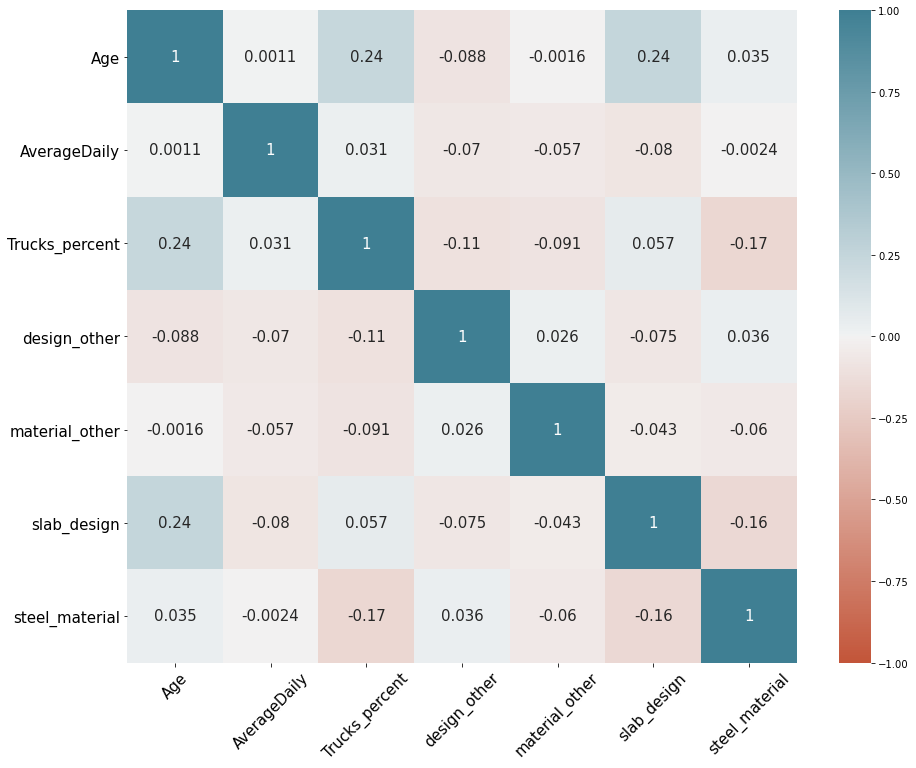

In [56]:
# Grabbing the predictor variables from the main table
continuous_correlation3 = table.pivot_table(values=['Age','AverageDaily', 'Trucks_percent', 'material_other', 'steel_material', 'design_other', 'slab_design'], index=['Structure_id'])
continuous_correlation3.corr()


# Heatmap for predictors' possible correlation using seaborn
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(continuous_correlation3.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20,220, as_cmap=True),
            annot=True, ax=ax, annot_kws={"size":15})

_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

The correlation heatmap (above) for the predictor varaibles being used later in the regression analysis shows no high correlation between the predictor variables. The analysis can proceed.

#### **Section 3.C: Dropping missing values from relevant columns of dataset**

Without removing the missing values in relevant parts of the dataset, the later regression could not work. The below code searches for, then drops them. Since it is only a few instances (6) when observation need to be dropped, it does not alter the dataset in any significant way. 

In [57]:
# Searching for and removing missing data in relevant (for regression) columns
print('Number of missing values:')
for col in table.columns:
    print('\t%s: %d' % (col,table[col].isna().sum()))

nulls = table[table['Total_Rating'].isna()]
nulls

table.dropna(subset = ["Total_Rating"], inplace=True)
table.dropna(subset = ['Deck_rating'], inplace=True)

Number of missing values:
	Year: 0
	Age: 0
	Historic: 0
	AverageDaily: 0
	Trucks_percent: 0
	Material: 0
	Design: 0
	Total_Rating: 6
	Deck_rating: 5
	Superstr_rating: 1
	Substr_rating: 0
	AverageDailyLog: 0
	TruckspercentLog: 0
	material_other: 0
	steel_material: 0
	design_other: 0
	slab_design: 0


#### **Section 3.D: Fitting the Regression Line**

In [58]:
y = table.Total_Rating # This is the target variable (constructed earlier from ordinal variables, but now being a continuous one)
X = np.column_stack((table.Age, table.AverageDaily, table.Trucks_percent, table.material_other, table.steel_material, table.design_other, table.slab_design))

We can now fit the regression, check the model's R2 coefficient then print the coefficients for each variable. 

In [59]:
reg = LinearRegression().fit(X, y)
print('The R2 coefficient of determination is %4.6f' % reg.score(X, y))
print()

The R2 coefficient of determination is 0.458388



#### **R2 Coefficient:**
R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

* `R-squared = Explained variation / Total variation` (always between 0 and 100%)

* 0% indicates that the model explains none of the variability of the response data around its mean.
* 100% indicates that the model explains all the variability of the response data around its mean.

The R^2, in this analyis, being ~0.45 is not a particularly good one. It basically means that 45% of the variation in Total_Rating is explained by the used predictor variables. From this value we already know before plotting the regression line to the data, that a large portion of the data will not fit on the line. Why? Because the more variance that is accounted for by the regression model, the closer the data points will fall to the fitted regression line. Theoretically, if a model could explain 100% of the variance, the fitted values would always equal the observed values and, therefore, all the data points would fall on the fitted regression line. 

Nonetheless, just because the R^2 is relatively low in this model, it does not mean that the relationships between predictor and target variables cannot be insightful (although their significance level could be calculated to decide whether they should be included in the model or not).

#### **Variables' coefficient results**

In [60]:
print('The intercept is %4.3f' % reg.intercept_)
print()
beta_Age, beta_AverageDaily, beta_Trucks_percent, beta_material_other, beta_steel_material, beta_design_other, beta_slab_design = reg.coef_
print('Continuous variables:')
print('Estimated regression coefficient for Age is %4.4f' % beta_Age, 
      'change of Total_Rating as Age increases by 1 year.')
print('Estimated regression coefficient for AverageDaily is %4.4f' % beta_AverageDaily,
      'change of Total_Rating as AverageDaily (that is, the average number of vehicles) increases.')
print('Estimated regression coefficient for Trucks_percent is %4.4f' % beta_Trucks_percent, 
      'change of Total_Rating as Trucks_percent increases by 1 percent.')
print()
print('Categorical variables:')
print('Estimated regression coefficient for material_other is %4.4f' % beta_material_other,
      'change of Total_Rating when material is Other.')
print('Estimated regression coefficient for steel_material is %4.4f' % beta_steel_material,
      'change of Total_Rating when material is Steel.')
print('Estimated regression coefficient for design_other is %4.4f' % beta_design_other,
      'change of Total_Rating when design is Other.')
print('Estimated regression coefficient for slab_design is %4.4f' % beta_slab_design,
      'change of Total_Rating when design is Slab.')

The intercept is 22.758

Continuous variables:
Estimated regression coefficient for Age is -0.0582 change of Total_Rating as Age increases by 1 year.
Estimated regression coefficient for AverageDaily is -0.0000 change of Total_Rating as AverageDaily (that is, the average number of vehicles) increases.
Estimated regression coefficient for Trucks_percent is 0.0055 change of Total_Rating as Trucks_percent increases by 1 percent.

Categorical variables:
Estimated regression coefficient for material_other is -2.8892 change of Total_Rating when material is Other.
Estimated regression coefficient for steel_material is -1.4396 change of Total_Rating when material is Steel.
Estimated regression coefficient for design_other is 0.0605 change of Total_Rating when design is Other.
Estimated regression coefficient for slab_design is 0.0300 change of Total_Rating when design is Slab.


#### **Comparing the Continuous Variable Coefficients**
It is really important to realise that the coefficients of a linear regression have units. The values will change if we scale the predictors. Because the units are different, we need to take care when we compare them. A solution is to make a comparison based on the distributions of (continuous) predictor and target variables. 

One way to proceed, therefore, is to look at the ranges of the predictor variables and the target variable. 

In [61]:
# Calculating ranges for Total_Rating, Age, AverageDaily and Trucks_percent
totalrating_range = table.Total_Rating.quantile(0.9) - table.Total_Rating.quantile(0.1)
age_range = table.Age.quantile(0.9) - table.Age.quantile(0.1)
averagedaily_range = table.AverageDaily.quantile(0.9) - table.AverageDaily.quantile(0.1)
truckspercent_range = table.Trucks_percent.quantile(0.9) - table.Trucks_percent.quantile(0.1)

print('Total_Rating range (10th to 90th centile) is %3.1f' % totalrating_range, 'scores')
print('Age range (10th to 90th centile) is %3.1f' % age_range, 'years')
print('AverageDaily range (10th to 90th centile) is %3.1f' % averagedaily_range, 'average number of vehicles')
print('Trucks_percent range (10th to 90th centile) is %3.1f' % truckspercent_range, 'percent')

Total_Rating range (10th to 90th centile) is 5.0 scores
Age range (10th to 90th centile) is 52.0 years
AverageDaily range (10th to 90th centile) is 31080.0 average number of vehicles
Trucks_percent range (10th to 90th centile) is 23.0 percent


We can then calculate the change in the target value as a percentage of its range that would result from the changing each of the predictor variables over its range. This gives a better comparison of the importance of the predictors. 

In [62]:
print('The change in Total_Rating (as a percent of its range) given by the Age coefficient (over its range) is %4.1f percent'
      % (100 * (beta_Age * age_range) / totalrating_range))
print('The change in Total_Rating (as a percent of its range) given by the AverageDaily coefficient (over its range) is %4.1f percent'
      % (100 * (beta_AverageDaily * averagedaily_range) / totalrating_range))
print('The change in Total_Rating (as a percent of its range) given by the Trucks_percent coefficient (over its range) is %4.1f percent'
      % (100 * (beta_Trucks_percent * truckspercent_range) / totalrating_range))

The change in Total_Rating (as a percent of its range) given by the Age coefficient (over its range) is -60.6 percent
The change in Total_Rating (as a percent of its range) given by the AverageDaily coefficient (over its range) is -0.0 percent
The change in Total_Rating (as a percent of its range) given by the Trucks_percent coefficient (over its range) is  2.6 percent


It is noticable how the interpretation of Age, AverageDaily and Trucks_percent have changed. In their initial, non-transformed form, both Age and Trucks_percent (mainly Age) implied modest influence on Total_Rating. After transformation, bridges' age influence over the target variable looks very significant. 

#### **Interpreting categorical coefficient outputs:**
Whilst the regression coefficient output is self-explanatory for the continuous variables (and stated above), it requires further explanation with regard to the categorical ones:<br>
**Material**: after transforming categorical values to binary variables, 'Concrete' became the reference group. That is:<br>
* Material 'Other' coefficient -2.8892 will mean a Total_Rating score change of -2.8892 once Material is changed from Concrete to 'Other'.
* Material 'Steel' coefficient -1.4396 will mean a Total_Rating score change of -1.4396 once Material is changed from Concrete to 'Steel'.

**Design**: similarly, after transforming categorical values of Design to binary variables, 'Beam' design became the reference group. That is: <br>
* Design 'Other' coefficient 0.0605 will mean a Total_Rating score change of 0.0605 once Design is changed from Beam to 'Other'.
* Design 'Slab' coefficient 0.0300 will mean a Total_Rating score change of 0.0300 once Design is changed from Beam to 'Slab'.

#### **Section 3.E: Prediction and the Error Distribution**

After calculating the predicted values of the target variable, the errors can be computed and their distribution shown as below. 

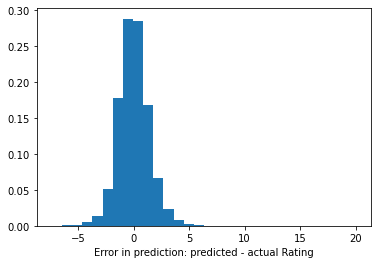

In [63]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=30, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual Rating')

The (approximately)`normal error distribution of the errors` imply that inferences made using the model about the relationship between target and predictor variables are valuable. To explain why the normality of residuals is important in making inferences can be illustrated with non-normality in the residuals. Non-normality of residuals would mean that the amount of error in the model is not consistent across the full range of the observed data. Meaning, the predictive ability of 'Age' in this analysis (calculated as beta coefficient) is not the same across the full range of variable Total_Rating. Therefore, its beta coefficient would basically mean different things at different levels of Total_Rating: at Total_Rating 10 it would actually be -0.0582 (as shown in output model), however at Total_Rating 20 it could have an effect of, let's say -1.3. This would certainly not help interpretation or gaining validity: in the case of this analysis, the regression model would not explain all trends in the dataset leaving unknown trends in the data set.

### **Section 3.F: Plotting the regression line**

We can also plot a scatter of the actual values against the predicted values. The plot generated below showcases the predicted value (blue line) and the actual values for Total_Rating in the dataset.

Text(0, 0.5, 'Actual Value')

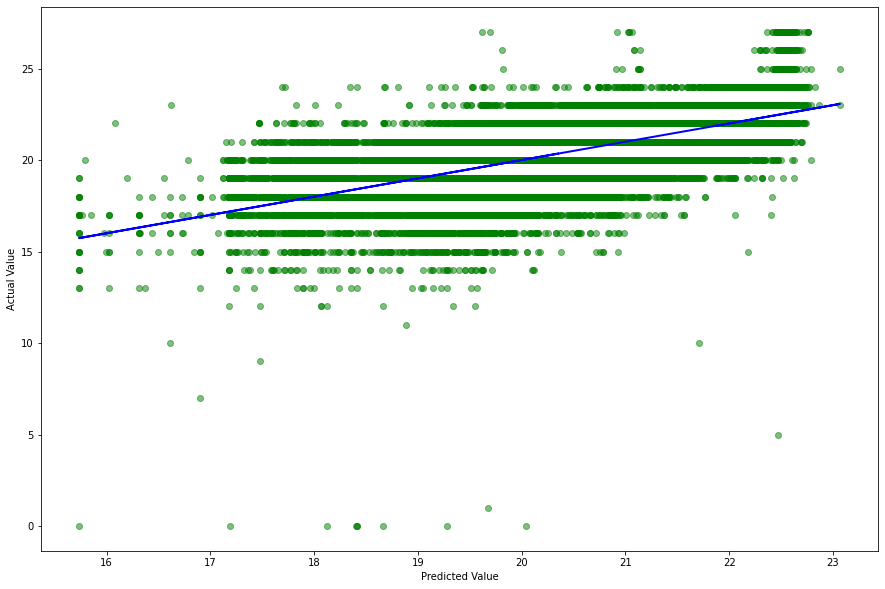

In [64]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='green', alpha=0.5)
a.plot(y_hat, y_hat, color='blue', linewidth=2)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.g', alpha=0.005)

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

**`Residuals`**<br>
A residual (vertical lines) is a measure of how far away a point is vertically from the regression line. Simply, it is the error between a predicted value (blue line above) and the observed actual values (green circles above). 

**`Residual Plots`**<br>
A typical residual plot has the residual values on the Y-axis and the independent variable on the x-axis. 

**`Residual Plot Analysis`**
The most important assumption of a linear regression model is that the **errors are independent and normally distributed**. 

Let's examine what this assumption means.

Every regression model inherently has some degree of error since you can never predict something 100% accurately. More improtantly, randomness and unpredictability are always a part of the regression model. Hence, a regression model can be explained as: `Response = Deterministic + Stochastic`. 

The deterministic part of the model is what we try to capture using the regression model. Ideally, our linear equation model should accurately capture the predictive information. Essentially, what this means is that if we capture all of the predictive information, all that is left behind (residuals) should be completely random and unpredictable (that is, stochastic). Hence, we want our residuals to follow a normal distribution. And that is exactly what we look for in a residual plot. So what are the characteristics of a good and bad residual plot?

**Characteristics of Good Residual Plots:**<br>
A few characteristics of a good residual plot are as follows:
1. It has a high density of points close to the origin and a low density of points away from the origin. 
2. It is symmetric about the origin. 
3. Independent of the value of an independent variable (x-axis), the residual errors are approximately distributed in the same manner. In other words, we do not see any patterns in the value of the residuals as we move along the x-axis. 

Hence, points 1 through 3 satisfies the earlier assumption that regression model residuals are independent and normally distributed. 

The below scatter plot plotted residuals on the y-axis against the model's predicted values for Total_Rating. Whilst point 2 and 3 is approximately satisfied, point 1 is not really fulfilled: a quite large density of the residuals deviate further away from the origin (red line) and more importantly, more than two standard deviation away (blue lines). Generally, the smaller the residual standard deviation, the better the model fits the data. This implies that although the model predict Total_Rating scores reasonably well, it could also be seriously improved. 

Text(0, 0.5, 'Residuals')

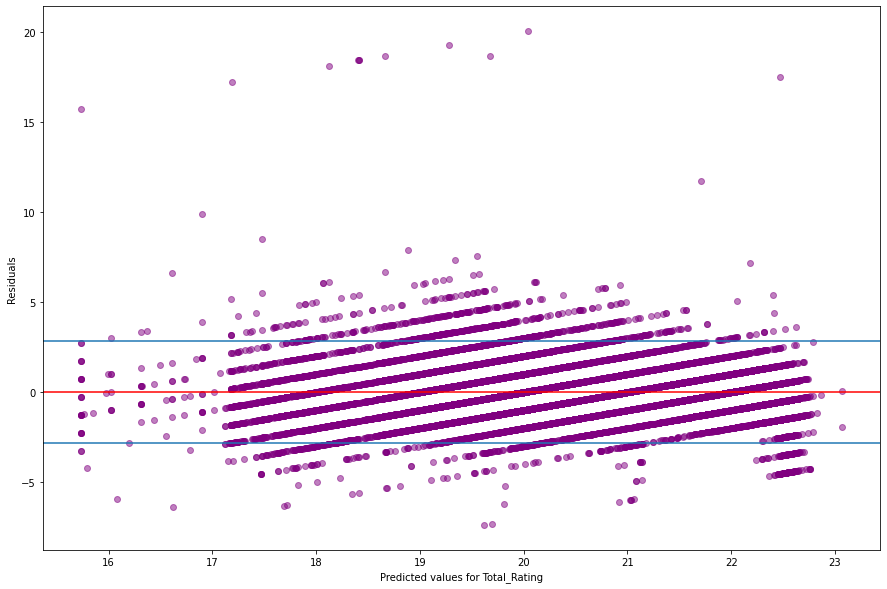

In [65]:
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, residuals,  color='purple', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=residuals.std()*2)
plt.axhline(y=residuals.std()*-2)

a.set_xlabel('Predicted values for Total_Rating')
a.set_ylabel('Residuals')

In [66]:
# # Calculating RMSE
# print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

### **Section 4: Final Conclusions and Suggestions**

**`Q1`** `How well the proposed variables can predict the bridge condition?`<br>
Although the model generally captures the main trend in Total_Ratings, the analysis suggested that there is relatively high residual deviation (actual value minus predicted value), implying that with different predictor variables (or complementing this current five) a better fit could have been achieved. The considerably low R2 value also suggests that there are other possible predictor variables that surely affect Total_Rating, however these variables are unknown. 

It would also be advisable to check how the dummy variables interact with the other three continuous variables (i.e., with interaction terms). The exploratory analysis part of this paper implied such possible relationships between them that are hidden in the applied regression model. For example, the dependence between Design and Material levels are not included in the model, nor Material's relationship with Age... If there is indeed a considerable relationship between them, the accuracy of the model could further be improved. 

**`Q2`** `Which of the proposed variables has more influence on the current condition?`<br>

Regular regression coefficients that the above model generated describe the relationship between each predictor variable and the response variable. The coefficient value represents the mean change in the response given a one-unit increase in the predictor. Consequently, it is easy to think that variables with larget coefficients are more important because they represent a larger change in the response. However, this is false. `Larger coefficients do not necessarily imply more important predictor variables.`

However, the units vary between the different types of variables, which makes it impossible to compare them directly. For example, the meaning of a one-unit change is very different in our analysis for the predictors. Age is measured in years (ranging from 2 to 72), AverageDaily is measured in daily average number of vehicles (ranging from 0 to 543,000), and Trucks_percent is measured in percentage (ranging from 0 to 99). 

This analysis multiplied each continuous predictor variables' beta coefficient with its own value range, multiplied by 100, then divided it with the range of Total_Rating (0 to 27). The result is a common ground between all variables that allows direct comparison of the influence of the continuous variables. Considering these transformed results, Age has the most influence on Total_Rating (-60.6 percent), followed by Trucks_percent (2.6 percent) and closing with AverageDaily (0 percent). 

As said earlier, dummy variables' importance can only be comparable between in their own respective levels. According to this, 'Other' material has the most influence on current condition (compared to concrete, it is -2.89 more), followed by 'Steel' material (compared to concrete, it is -1.43 more). With regard to Design's levels, 'Other' design has the most influence on current condition (compared to Beam, it is 0.06 more), followed by 'Slab' design (compared to Beam, it is 0.03 more). Neither Material or Design's reference group's coefficient is available from the current set-up of the model.

With this, the analysis is complete. If you have any queries or suggestions for altering the model, do not hesitate to contact us. 